# Fire Image Classification

- Dataset -> https://github.com/cair/Fire-Detection-Image-Dataset

- There are three main stages in the process of fire image detection algorithms: image preprocessing, image extraction, and fire detection.

In [94]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# input path for the images
fire_img_path = "./images/Fire images/"
normal_img_path = "./images/Normal img/"



Let's load and plot the first five normal images in a single figure. 

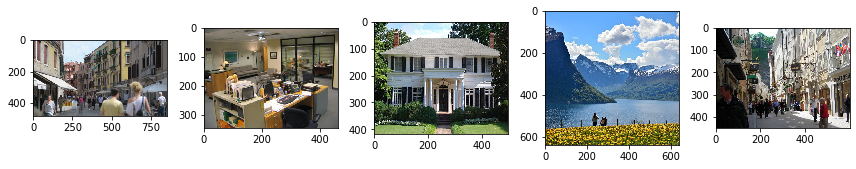

In [180]:
cpt = 0
plt.figure(0, figsize=(12,20))

for i in range(1,6):
    cpt += 1
    plt.subplot(2,5,cpt)
    img = load_img(normal_img_path + os.listdir(normal_img_path)[i])
    plt.imshow(img, cmap="gray")
    
plt.tight_layout()
plt.show()

Looking at a few random images in the directory, we can see that the images are color and have different sizes and shapes.

The images will have to be reshaped prior to modeling.

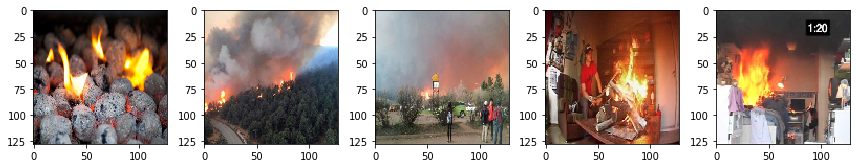

In [95]:
cpt = 0
pic_size = 128
plt.figure(0, figsize=(12,20))

for i in range(1,6):
    cpt += 1
    plt.subplot(2,5,cpt)
    img = load_img(fire_img_path + os.listdir(fire_img_path)[i], target_size=(pic_size, pic_size))
    plt.imshow(img, cmap="gray")
    
plt.tight_layout()
plt.show()

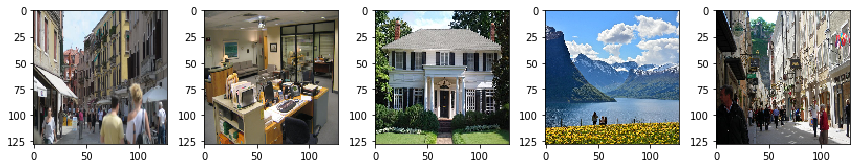

In [96]:
cpt = 0
plt.figure(0, figsize=(12,20))

for i in range(1,6):
    cpt += 1
    plt.subplot(2,5,cpt)
    img = load_img(normal_img_path + os.listdir(normal_img_path)[i], target_size=(pic_size, pic_size))
    plt.imshow(img, cmap="gray")
    
plt.tight_layout()
plt.show()

In [97]:
df = pd.read_csv('dataset/fire-detection.csv')

In [98]:
df = df.drop(['Unnamed: 0', 'Folder'], axis=1)
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


In [99]:
# Copyright 2014-2017 Bert Carremans
# Author: Bert Carremans <bertcarremans.be>
#
# License: BSD 3 clause


import os
import random
from shutil import copyfile

def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    else:
        if not os.path.exists('data/train'):
            os.makedirs('data/train')
        if not os.path.exists('data/validation'):
            os.makedirs('data/validation')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('data/train', subdir)
        validation_subdir = os.path.join('data/validation', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/validation/' + subdir)


In [100]:
img_source_dir = "./images"
img_train_test_split(img_source_dir, .7)

Copied 367 images to data/train/Normal img
Copied 162 images to data/validation/Normal img
Copied 78 images to data/train/Fire images
Copied 32 images to data/validation/Fire images


In [101]:
df['label'].value_counts()

0    543
1    110
Name: label, dtype: int64

In [102]:
from keras.preprocessing.image import ImageDataGenerator

pic_size =128
batch_size = 8

train_datagen = ImageDataGenerator(rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    validation_split=0.4)

train_generator = train_datagen.flow_from_directory("data/train/",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True)

Found 428 images belonging to 2 classes.


In [103]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory("data/validation/",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

Found 187 images belonging to 2 classes.


In [104]:
example_generator = train_datagen.flow_from_directory("example/",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True)


Found 1 images belonging to 1 classes.


## See how our generator works

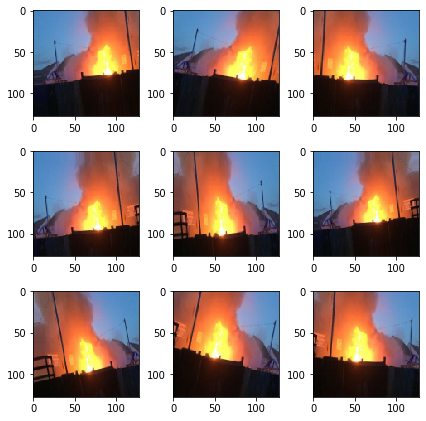

In [187]:
plt.figure(figsize=(6, 6))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [106]:
import cv2
from PIL import Image

img_pil = Image.open(normal_img_path + os.listdir(normal_img_path)[1])
print('Pillow: ', img_pil.mode, img_pil.size)

img = cv2.imread(normal_img_path + os.listdir(normal_img_path)[1], cv2.IMREAD_UNCHANGED)
print('OpenCV: ', img.shape)

Pillow:  RGB (852, 480)
OpenCV:  (480, 852, 3)


In [107]:
from tensorflow.keras.optimizers import SGD

num_classes = 1
# img_channels refers to number of colors
img_channels = 3
input_shape = (pic_size, pic_size, img_channels)

model = Sequential()

#1st layer is input layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd layer
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd layer
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)       

The problem is a binary classification task, requiring the prediction of one value of either 0 or 1. An output layer with 1 node and a sigmoid activation will be used and the model will be optimized using the binary cross-entropy loss function.

In [108]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#One way to avoid overfitting is to terminate the process early using earlystop
earlystop = EarlyStopping(patience = 10)

# Following line will reduce learning rate when a metric has stopped improving. 
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)

callbacks = [earlystop,learning_rate_reduction]

In [109]:
epochs = 3
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=validation_generator.n//validation_generator.batch_size

model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//batch_size,
#     steps_per_epoch=train_df.shape[0]//batch_size,
#     callbacks=callbacks)
    validation_steps=step_size_valid,
    steps_per_epoch=step_size_train)

Epoch 1/3
65/65 [==============================] - 93s 1s/step - loss: 0.8617 - accuracy: 0.7031 - val_loss: 7.7486e-07 - val_accuracy: 0.7734
Epoch 2/3
65/65 [==============================] - 87s 1s/step - loss: 0.5349 - accuracy: 0.7849 - val_loss: 0.0590 - val_accuracy: 0.8049
Epoch 3/3
65/65 [==============================] - 74s 1s/step - loss: 0.5331 - accuracy: 0.8173 - val_loss: 5.1580e-04 - val_accuracy: 1.0000


In [110]:
_, acc = model.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=0)
print('Accuracy: %.3f' % (acc * 100.0))

Accuracy: 84.492


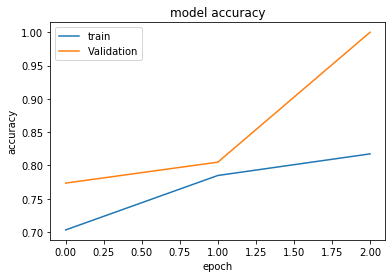

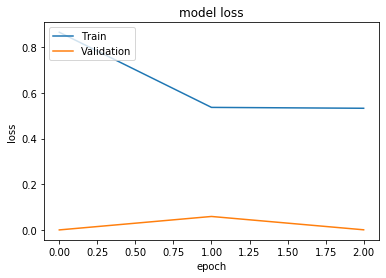

In [111]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [112]:
model.save('final_model.h5')

In [113]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory("test/",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)


Found 9 images belonging to 1 classes.


In [114]:
step_size_test = test_generator.n//test_generator.batch_size

test_generator.reset()
predict = model.predict_generator(test_generator, steps=step_size_test)

In [133]:
from keras.models import load_model

def load_image(filename):
    img = load_img(filename, target_size=(pic_size, pic_size))
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, pic_size, pic_size, img_channels)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

def run_example(filename):
    img = load_image(filename)
    model = load_model('final_model.h5')
    result = model.predict(img)
    return result[0]

In [137]:
labels = []
test_img_path = "test/all_classes/"
for i in range(1,6):
    labels.append(run_example(test_img_path + os.listdir(test_img_path)[i]))


<Figure size 864x1440 with 0 Axes>

{'Fire images': 0, 'Normal img': 1}


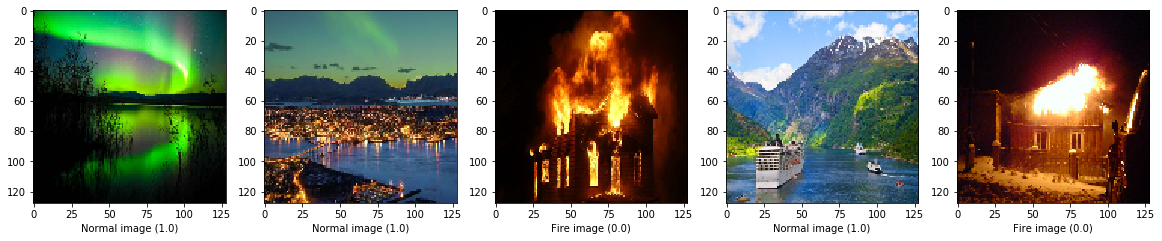

In [149]:
cpt = 0
pic_size = 128
plt.figure(0, figsize=(20,20))

print(train_generator.class_indices)
for i in range(1,6):
    cpt += 1
    plt.subplot(1,5,cpt)
    img = load_img(test_img_path + os.listdir(test_img_path)[i], target_size=(pic_size, pic_size))
    plt.imshow(img)
    cl = 'Fire image' if labels[i-1][0] == 0 else 'Normal image'
    plt.xlabel(cl + ' (' + "{}".format(labels[i-1][0]) + ')' )


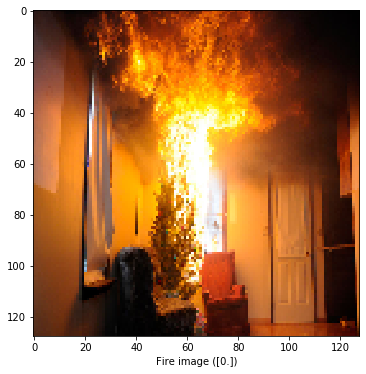

In [88]:
def predict_fire(filename):
    plt.figure(figsize=(6, 6))
    img = load_img(filename, target_size=(pic_size,pic_size))
    plt.imshow(img)
    label = model.predict(load_image(filename))[0]
    cl = 'Fire image' if label == 0 else 'Normal image'
    plt.xlabel(cl + ' (' + "{}".format(label) + ')' )

filename = 'christmas_tree_fire.jpg'
predict_fire(filename)

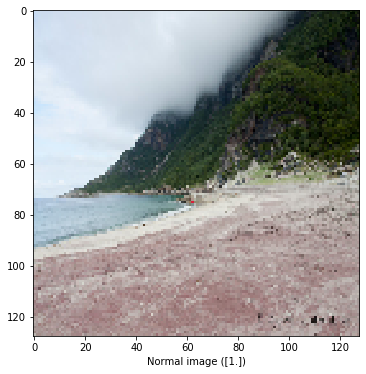

In [89]:
filename = 'Bodoe_aug2010x17.jpg'
predict_fire(filename)

In [166]:
labels1 = []
test_img_path = "test/all_classes/"
for i in range(1,15):
    labels1.append(run_example(test_img_path + os.listdir(test_img_path)[i]))


In [ ]:
cpt = 0
pic_size = 128
plt.figure(0, figsize=(10,10))



{'Fire images': 0, 'Normal img': 1}


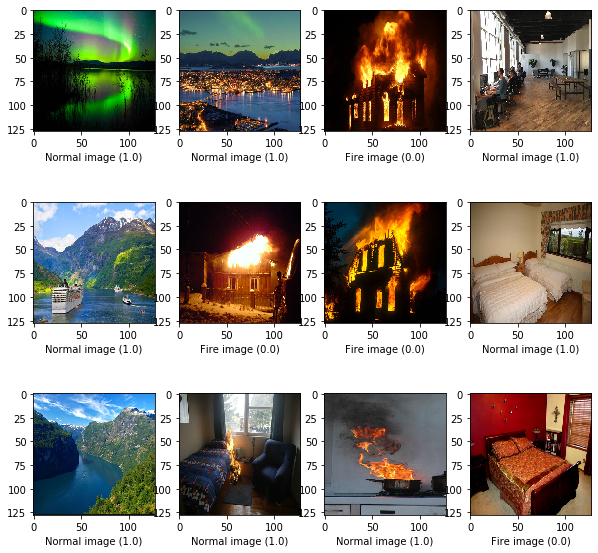

In [174]:
print(train_generator.class_indices)
for i in range(1,13):
    cpt += 1
    plt.subplot(3,4,cpt)
    img = load_img(test_img_path + os.listdir(test_img_path)[i], target_size=(pic_size, pic_size))
    plt.imshow(img)
    cl = 'Fire image' if labels1[i-1][0] == 0 else 'Normal image'
    plt.xlabel(cl + ' (' + "{}".format(labels1[i-1][0]) + ')' )

### What caused these incorrect classifications?
- Our dataset is small
    - We only have 650 images in total
    
- We only work with raw images

